# AI Tensorflow Project #2
Build and test a convolutional neural network for Traffic Sign Recognition using tensorflow

# Import tensorflow and Traffic sign data

In [18]:
# Load pickled data
import pickle
import tensorflow as tf
from sklearn.utils import shuffle
from tensorflow.contrib.layers import flatten
import matplotlib.pyplot as plt
import numpy as np
# TODO: Fill this in based on where you saved the training and testing data

training_file = "train.p"
validation_file="valid.p"
testing_file = "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']



X_train=X_train.reshape([X_train.shape[0],-1])
X_valid=X_valid.reshape([X_valid.shape[0],-1])
X_test=X_test.reshape([X_test.shape[0],-1])

X_train = (X_train/127.5-1.0)
X_valid = (X_valid/127.5-1.0)
X_test = (X_test/127.5-1.0)
print (X_train.shape, y_train.shape)
print (X_valid.shape, y_valid.shape)
print (X_test.shape, y_test.shape)
num_samples=X_train.shape[0]

#shuffle training data
X_train, y_train=shuffle( X_train, y_train)    


(34799, 3072) (34799,)
(4410, 3072) (4410,)
(12630, 3072) (12630,)


# Define input/output

In [ ]:
# MNIST data input (img shape: 32*32)
num_input = 32*32*3
# Traffic sign total classes 
num_classes = 43

# placeholders for input and output
X = tf.placeholder(tf.float32, [None, num_input])
Y = tf.placeholder(tf.int32, [None])

# Hyperparameters!!

In [ ]:
# Parameters and model hyper-paramters
learning_rate = 0.0005 #0.001
#num_steps = 1000
batch_size = 128
display_step = 10
EPOCHS=3
target_accuracy=0.9

In [4]:

def gen_batch(X, y, num_examples, batch_size):
    for offset in range(0, num_examples, batch_size):
        end = offset + batch_size
        if(end<=num_examples):
            batch_x, batch_y = X[offset:end], y[offset:end]
            yield (batch_x, batch_y)


In [22]:
def plot_curve(curve,Title,learning_rate,line_num=1):
    lab=["train","val","test"]
    plt.title(Title)
    x=range(len(curve))
    c1=np.array(curve)
    for k in range(line_num):
        plt.plot(x,c1[:,k],linestyle="-", label=lab[k])
        plt.legend(loc='upper right',title=learning_rate)
    plt.show()    



# Define evaluation method without core neural network yet

In [37]:
import time
def get_time():
    t = time.time()
    return t
def evaluate(logits, retrain=False):
    acc_list=[]
    loss_list=[]
    prediction = tf.nn.softmax(logits)
    one_hot_Y = tf.one_hot(Y, 43)
    cost_function = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_Y))
    
    # Check out other optimzers, basically compared to GD or SGD, Adam 
    # introduced momentum to (1) more effectively train (2) protect from local
    # minimal better; and adaptively adjust learning speed more effectively to
    # converge faster, than gradient descent
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(cost_function)

    # Evaluate model
    correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(one_hot_Y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    # Start training
    with tf.Session() as sess:
        saver=tf.train.Saver()
        if(retrain==False):
            sess.run(tf.global_variables_initializer())
        else:
            saver.restore(sess,"./cnn")
        for iter in range(EPOCHS):
            t0=get_time()
            num_steps=int(num_samples/batch_size)
            i_X_train, i_y_train=shuffle( X_train[:num_samples,:], y_train[:num_samples])    
            
            for batch_x, batch_y in gen_batch(i_X_train, i_y_train, num_samples, batch_size):
                sess.run(train_op, feed_dict={X: batch_x, Y: batch_y})
            train_loss, train_accuracy = sess.run([cost_function, accuracy],
                                 feed_dict={X: i_X_train, Y: i_y_train})
            valid_loss, valid_accuracy = sess.run([cost_function, accuracy], 
                                feed_dict={X: X_valid,Y: y_valid})
            test_loss, test_accuracy = sess.run([cost_function, accuracy],
                                 feed_dict={X: X_test, Y: y_test})
            t1=get_time()
            print("%d, %.3f ,train:%.5f,%.3f, valid:%.5f, %.3f, test:%.5f, %.3f, " \
                  %(iter,(t1-t0), \
                    train_accuracy,train_loss,\
                    valid_accuracy, valid_loss,\
                      test_accuracy, test_loss))
            acc_list.append([train_accuracy,valid_accuracy, test_accuracy])
            loss_list.append([train_loss,valid_loss, test_loss])

            saver.save(sess, './cnn')
            if(valid_accuracy>target_accuracy):
                break
        print("Optimization Finished!")

# Calculate accuracy for  train/valid/test images

        print("Final Training Accuracy:", \
            sess.run(accuracy, feed_dict={X: X_train,
                                          Y: y_train}))

        print("Final Valid Accuracy:", \
            sess.run(accuracy, feed_dict={X: X_valid,
                                          Y: y_valid}))
        print("Final Testing Accuracy:", \
            sess.run(accuracy, feed_dict={X: X_test,
                                          Y: y_test}))
    return acc_list,loss_list

# Experiment 1, use 3 layer CNN + 1 Dense used in MNIST


In [49]:
dropout_rate = 0.5 #

def neural_net_convolution(x):
    images_2d=tf.reshape(x,[-1,32,32,3])
    conv_1 = tf.layers.conv2d(
        inputs=images_2d,
        filters=16,
        kernel_size=[5,5],
        activation=tf.nn.relu,
        strides=(2, 2), # default strides is 1x1
        padding="same", # or "valid" to shrink the output size
    )

    pool_1 = tf.layers.max_pooling2d(
        inputs=conv_1,
        pool_size=[2,2],
        strides=2)
    conv_2 = tf.layers.conv2d(
        inputs=pool_1,
        filters=16,
        kernel_size=[5,5],
        activation=tf.nn.relu,
        #strides=(2, 2), # default strides is 1x1
        padding="same")

    pool_2 = tf.layers.max_pooling2d(
        inputs=conv_2,
        pool_size=[2,2],
        strides=2)
    conv_3 = tf.layers.conv2d(
        inputs=pool_2,
        filters=16,
        kernel_size=[5,5],
        activation=tf.nn.relu,
        #strides=(2, 2), # default strides is 1x1
        padding="same")
    pool_3 = tf.layers.max_pooling2d(
        inputs=conv_3,
        pool_size=[2,2],
        strides=2)
    dropout_3 = tf.layers.dropout(
        inputs=conv_3,
        rate=dropout_rate)

    output_linear=flatten(pool_3)
    out_y = tf.layers.dense(
    inputs=output_linear,
    units=43,
    activation=None)

    return conv_1, conv_2, out_y

In [50]:
EPOCHS=10
num_samples=256
batch_size=16
learning_rate=0.0005
conv_1, conv_2, out_y = neural_net_convolution(X)
acc_list, loss_list = evaluate(out_y)

0, 10.570 ,train:0.00391,3.673, valid:0.00680, 3.712, test:0.00784, 3.694, 
1, 11.578 ,train:0.10547,3.545, valid:0.05669, 3.667, test:0.08036, 3.616, 
2, 11.509 ,train:0.10938,3.400, valid:0.08662, 3.682, test:0.08100, 3.582, 
3, 10.769 ,train:0.12109,3.291, valid:0.08050, 3.665, test:0.08504, 3.536, 
4, 11.134 ,train:0.13672,3.201, valid:0.08163, 3.688, test:0.09010, 3.526, 
5, 10.659 ,train:0.14453,3.130, valid:0.09116, 3.681, test:0.08892, 3.511, 
6, 10.662 ,train:0.18359,3.064, valid:0.09320, 3.697, test:0.09596, 3.511, 
7, 11.085 ,train:0.23828,2.994, valid:0.10136, 3.716, test:0.12249, 3.510, 
8, 10.589 ,train:0.25391,2.906, valid:0.11474, 3.712, test:0.13159, 3.495, 
9, 11.147 ,train:0.26172,2.816, valid:0.11814, 3.715, test:0.14996, 3.473, 
Optimization Finished!
Final Training Accuracy: 0.13853846
Final Valid Accuracy: 0.11814059
Final Testing Accuracy: 0.14996041


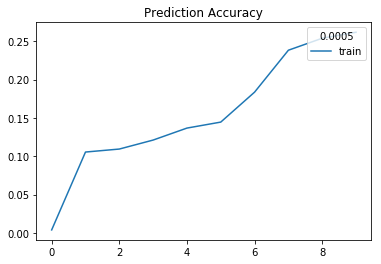

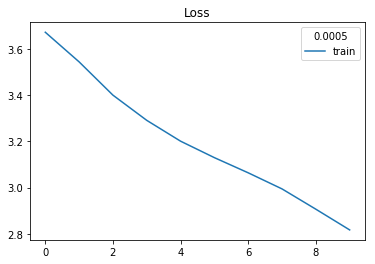

In [51]:
plot_curve(acc_list, "Prediction Accuracy", learning_rate)   
plot_curve(loss_list, "Loss", learning_rate)   

In [27]:
dropout_rate = 0.5 #

def neural_net_convolution(x):
    images_2d=tf.reshape(x,[-1,32,32,3])
    conv_1 = tf.layers.conv2d(
        inputs=images_2d,
        filters=16,
        kernel_size=[5,5],
        activation=tf.nn.relu,
        #strides=(2, 2), # default strides is 1x1
        padding="same", # or "valid" to shrink the output size
    )

    pool_1 = tf.layers.max_pooling2d(
        inputs=conv_1,
        pool_size=[2,2],
        strides=2)

    output_linear=flatten(pool_1)
    
    dense_1 = tf.layers.dense(
    inputs=output_linear,
    units=256,
    activation=None)
    
    dense_2 = tf.layers.dense(
    inputs=dense_1,
    units=256,
    activation=None)

    out_y = tf.layers.dense(
    inputs=dense_2,
    units=43,
    activation=None)

    return conv_1, out_y

In [15]:
EPOCHS=10
num_samples=256
batch_size=16
learning_rate=0.0005
layer_1, out_y = neural_net_convolution(X)
acc_list, loss_list = evaluate(out_y)
plot_curve(acc_list, "Prediction Accuracy", learning_rate)   
plot_curve(loss_list, "Loss", learning_rate)  

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

0, 9.663 ,train:0.28906,2.808, valid:0.12132, 3.562, test:0.12130, 3.500, 
1, 10.049 ,train:0.45312,2.215, valid:0.18299, 3.356, test:0.21734, 3.221, 
2, 10.561 ,train:0.55078,1.723, valid:0.19501, 3.365, test:0.22169, 3.209, 
3, 9.881 ,train:0.63281,1.386, valid:0.22812, 3.381, test:0.25875, 3.142, 
4, 9.679 ,train:0.74609,1.067, valid:0.25828, 3.366, test:0.28876, 3.120, 
5, 10.310 ,train:0.81250,0.861, valid:0.30181, 3.112, test:0.31203, 2.944, 
6, 9.811 ,train:0.82031,0.692, valid:0.32358, 3.285, test:0.35202, 3.009, 
7, 9.823 ,train:0.89453,0.560, valid:0.33311, 3.231, test:0.32898, 3.000, 
8, 9.850 ,train:0.94141,0.427, valid:0.35465, 3.277, test:0.36833, 2.987, 
9, 9.895 ,train:0.89453,0.387, valid:0.31020, 3.513, test:0.35170, 3.184, 
Optimization Finished!
Final Training Accuracy: 0.40550

NameError: name 'plt' is not defined

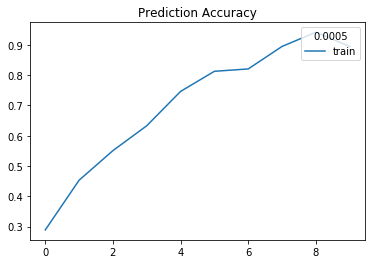

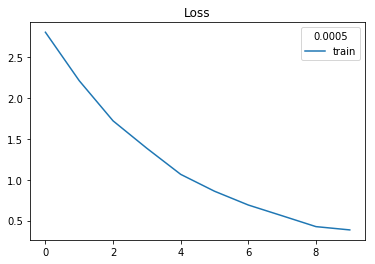

In [23]:
plot_curve(acc_list, "Prediction Accuracy", learning_rate, line_num=1)   
plot_curve(loss_list, "Loss", learning_rate, line_num=1)  

0, 10.843 ,train:0.05859,38.170, valid:0.03220, 40.768, test:0.03808, 42.540, 
1, 11.106 ,train:0.13281,17.790, valid:0.05442, 22.863, test:0.08496, 20.250, 
2, 10.948 ,train:0.16016,3.440, valid:0.06009, 4.021, test:0.07846, 4.119, 
3, 11.411 ,train:0.17188,3.361, valid:0.08435, 4.404, test:0.07633, 4.360, 
4, 11.389 ,train:0.21484,2.937, valid:0.10635, 3.935, test:0.11077, 3.757, 
5, 11.256 ,train:0.30859,2.669, valid:0.15442, 4.497, test:0.13713, 4.284, 
6, 11.025 ,train:0.30859,2.489, valid:0.12744, 3.873, test:0.12613, 3.717, 
7, 11.026 ,train:0.42969,2.229, valid:0.14308, 3.954, test:0.16698, 3.773, 
8, 10.077 ,train:0.46875,2.054, valid:0.16712, 3.708, test:0.19675, 3.601, 
9, 10.320 ,train:0.55859,1.657, valid:0.17914, 3.740, test:0.21006, 3.676, 
Optimization Finished!
Final Training Accuracy: 0.22851232
Final Valid Accuracy: 0.17913832
Final Testing Accuracy: 0.21005543


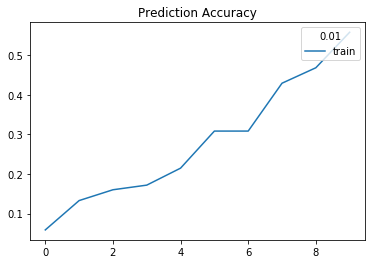

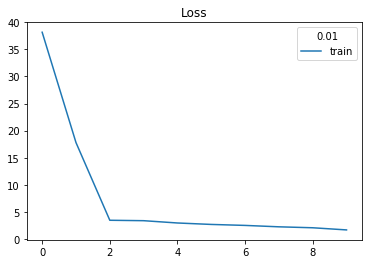

In [32]:
EPOCHS=10
num_samples=256
batch_size=16
learning_rate=0.01
conv_1, out_y = neural_net_convolution(X)
acc_list, loss_list = evaluate(out_y)
plot_curve(acc_list, "Prediction Accuracy", learning_rate)   
plot_curve(loss_list, "Loss", learning_rate) 

0, 10.332 ,train:0.27344,2.949, valid:0.13311, 3.571, test:0.14062, 3.428, 
1, 10.125 ,train:0.36719,2.567, valid:0.14422, 3.434, test:0.16437, 3.273, 
2, 10.369 ,train:0.45703,2.248, valid:0.18639, 3.328, test:0.22763, 3.147, 
3, 9.967 ,train:0.56641,1.907, valid:0.21043, 3.200, test:0.27276, 2.984, 
4, 10.123 ,train:0.65234,1.652, valid:0.23900, 3.170, test:0.28939, 2.926, 
5, 10.252 ,train:0.68359,1.421, valid:0.24172, 3.168, test:0.30095, 2.890, 
6, 10.039 ,train:0.71875,1.221, valid:0.26735, 3.118, test:0.33072, 2.824, 
7, 10.191 ,train:0.80078,1.052, valid:0.30952, 3.076, test:0.36675, 2.778, 
8, 11.607 ,train:0.80859,0.911, valid:0.31247, 3.069, test:0.36097, 2.773, 
9, 11.998 ,train:0.84766,0.797, valid:0.31474, 3.050, test:0.37324, 2.763, 
Optimization Finished!
Final Training Accuracy: 0.39136183
Final Valid Accuracy: 0.31473923
Final Testing Accuracy: 0.37323833


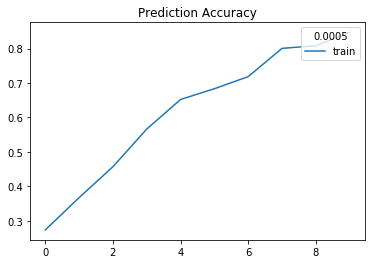

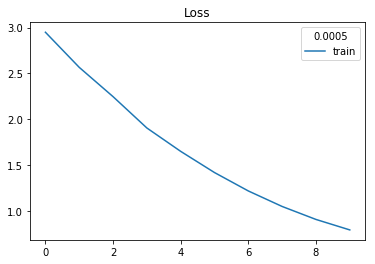

In [30]:
EPOCHS=10
num_samples=256
batch_size=64
learning_rate=0.0005
conv_1, out_y = neural_net_convolution(X)
acc_list, loss_list = evaluate(out_y)
plot_curve(acc_list, "Prediction Accuracy", learning_rate)   
plot_curve(loss_list, "Loss", learning_rate) 

0, 142.874 ,train:0.93569,0.291, valid:0.81927, 0.634, test:0.84252, 0.688, 
1, 115.660 ,train:0.95077,0.179, valid:0.83900, 0.607, test:0.85202, 0.718, 
2, 122.094 ,train:0.96747,0.126, valid:0.85692, 0.604, test:0.86762, 0.703, 
3, 100.917 ,train:0.97339,0.101, valid:0.87460, 0.558, test:0.87815, 0.740, 
4, 115.735 ,train:0.98399,0.062, valid:0.87687, 0.594, test:0.88694, 0.745, 
5, 122.221 ,train:0.97687,0.073, valid:0.87982, 0.731, test:0.87965, 0.875, 
6, 121.627 ,train:0.98825,0.044, valid:0.86871, 0.814, test:0.88124, 0.945, 
7, 99.114 ,train:0.98655,0.052, valid:0.87596, 0.644, test:0.88385, 0.877, 
8, 116.593 ,train:0.98750,0.039, valid:0.90045, 0.569, test:0.89327, 0.888, 
Optimization Finished!
Final Training Accuracy: 0.98749965
Final Valid Accuracy: 0.9004535
Final Testing Accuracy: 0.89327


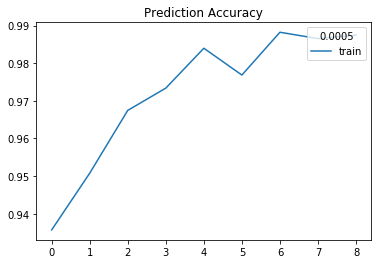

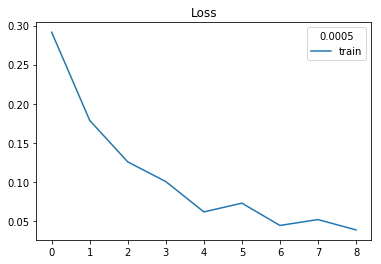

In [33]:
EPOCHS=10
batch_size=128
learning_rate=0.0005
num_samples=X_train.shape[0]

conv_1, out_y = neural_net_convolution(X)
acc_list, loss_list = evaluate(out_y)
plot_curve(acc_list, "Prediction Accuracy", learning_rate)   
plot_curve(loss_list, "Loss", learning_rate)    

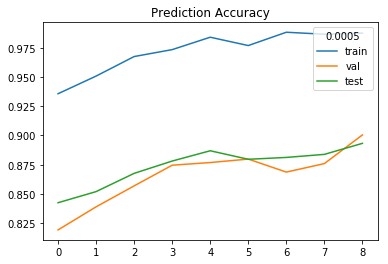

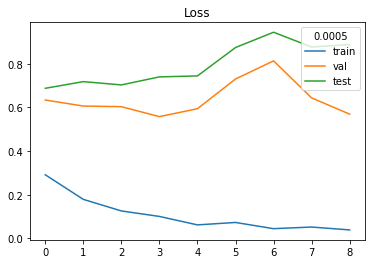

In [35]:
plot_curve(acc_list, "Prediction Accuracy", learning_rate, 3)   
plot_curve(loss_list, "Loss", learning_rate,3) 

In [39]:
target_accuracy=0.93
with tf.Session() as sess:
    #saver.restore(sess, tf.train.latest_checkpoint('.'))
    saver = tf.train.Saver()
    saver.restore(sess, './cnn')
    conv_1, out_y = neural_net_convolution(X)
    acc_list, loss_list = evaluate(out_y)

INFO:tensorflow:Restoring parameters from ./cnn
0, 129.676 ,train:0.93141,0.305, valid:0.80249, 0.721, test:0.81275, 0.732, 
1, 128.173 ,train:0.96198,0.150, valid:0.85873, 0.576, test:0.86302, 0.632, 
2, 128.534 ,train:0.97477,0.105, valid:0.85351, 0.649, test:0.86611, 0.698, 
3, 122.713 ,train:0.97899,0.081, valid:0.88526, 0.551, test:0.88314, 0.648, 
4, 115.697 ,train:0.98253,0.071, valid:0.88367, 0.593, test:0.89074, 0.632, 
5, 138.749 ,train:0.98908,0.045, valid:0.89252, 0.572, test:0.89414, 0.685, 
6, 124.268 ,train:0.98583,0.055, valid:0.87143, 0.698, test:0.88306, 0.759, 
7, 119.136 ,train:0.99195,0.034, valid:0.89615, 0.610, test:0.89208, 0.743, 
8, 115.198 ,train:0.98836,0.044, valid:0.90023, 0.547, test:0.88504, 0.846, 
9, 137.894 ,train:0.98836,0.040, valid:0.89660, 0.634, test:0.88892, 0.862, 
Optimization Finished!
Final Training Accuracy: 0.9883617
Final Valid Accuracy: 0.89659864
Final Testing Accuracy: 0.8889153


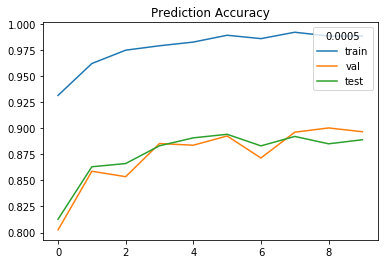

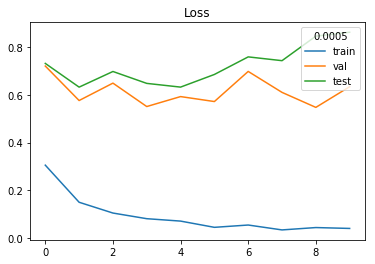

In [40]:
plot_curve(acc_list, "Prediction Accuracy", learning_rate, 3)   
plot_curve(loss_list, "Loss", learning_rate,3) 

In [41]:
%matplotlib inline
import math
import matplotlib.pyplot as plt
import numpy as np
def visualizeActivations(layer, image_to_use):
    plt.figure(1, figsize=(15,15))
    image_to_use = np.reshape(image_to_use,[1,3072])
    units = sess.run(layer, feed_dict={X: image_to_use})
    filters = units.shape[3]
    n_columns = 6 # columns per row
    n_rows = math.ceil(filters / n_columns) + 1
    for i in range(filters):
        plt.subplot(n_rows, n_columns, i+1)
    # plt.title('Filter ' + str(i + 1))
        plt.imshow(units[0,:,:,i], interpolation="nearest", cmap="gray")

2
1
25
8
12


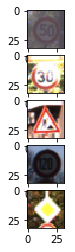

In [44]:
num=5
#plt.figure(1, figsize=(5,5))
for k in range(num):
    plt.subplot(num, 1, k+1)
    plt.imshow(((X_train[k]+1)*127.5/256).reshape(32,32,3))
    print (y_train[k])
plt.show()

INFO:tensorflow:Restoring parameters from ./cnn


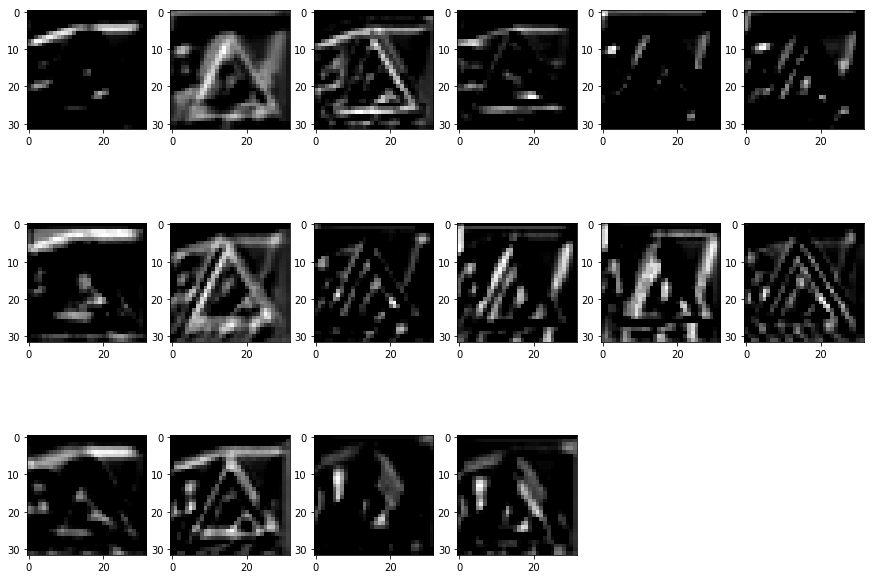

In [48]:
image_to_use = X_train[2];
with tf.Session() as sess:
    saver = tf.train.Saver()
    saver.restore(sess, "./cnn")
    visualizeActivations(conv_1, image_to_use)